In [1]:
import numpy as np
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
import os
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn.metrics.pairwise as smp
from sklearn.datasets import make_swiss_roll 
from sklearn.manifold import MDS 
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import random
from scipy import spatial 
from math import comb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef, f1_score
import time
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, recall_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve

### Reading & Preparing Data 

In [2]:
df_train = pd.read_csv(r'C:\Users\IKG\Desktop\HW5\IE582_Spring21_Final_Exam_Data\train.csv')
df_test = pd.read_csv(r'C:\Users\IKG\Desktop\HW5\IE582_Spring21_Final_Exam_Data\test.csv')

In [3]:
train_appids = df_train.loan_application_id.unique()
test_appids = df_test.loan_application_id.unique()

In [4]:
df_all = df_train.append(df_test)

In [5]:
df_all[['customer_age']].describe(percentiles=[ 0,0.1 ,0.2,0.3,0.4, 0.50, 0.6,0.7,0.8 ,0.90,1 ]).transpose()

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
customer_age,2562.0,41.556596,13.898195,19.0,19.0,24.0,27.0,32.0,36.0,40.0,45.0,50.0,55.0,62.0,74.0,74.0


In [6]:
df_all['age_segment'] = np.where(df_all['customer_age'] < 30, "18-30",
                                np.where(df_all['customer_age'] < 40, "30-40",
                                         np.where(df_all['customer_age'] < 53, "40-53","53+")))

In [7]:
df_all[['loan_amount']].describe(percentiles=[ 0,0.1 ,0.2,0.3,0.4, 0.50, 0.6,0.7,0.8 ,0.90,1 ]).transpose()

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
loan_amount,2562.0,2965.7226,1350.226463,771.0,771.0,1464.55,1770.4,2124.6,2420.4,2676.75,3079.2,3581.4,3924.4,4569.15,7994.0,7994.0


In [8]:
df_all['loan_amount_segment'] = np.where(df_all['loan_amount'] < 1800, "<1800",
                                np.where(df_all['loan_amount'] < 2800, "<2800",
                                         np.where(df_all['loan_amount'] < 3800, "<3800","3800+")))

In [9]:
# I will label encode Var 39 and 53 since they are Y or N.
df_all['Var_39'] = df_all['Var_39'].astype('category')
df_all['Var_39'] = df_all['Var_39'].cat.codes
df_all['Var_53'] = df_all['Var_53'].astype('category')
df_all['Var_53'] = df_all['Var_53'].cat.codes
df_all['age_segment'] = df_all['age_segment'].astype('category')
df_all['age_segment'] = df_all['age_segment'].cat.codes
df_all['loan_amount_segment'] = df_all['loan_amount_segment'].astype('category')
df_all['loan_amount_segment'] = df_all['loan_amount_segment'].cat.codes

In [10]:
print(df_train.shape,df_test.shape,df_all.shape)

(1715, 63) (847, 63) (2562, 65)


In [11]:
df_all = df_all.set_index('loan_application_id')

In [12]:
df_train_new = df_all.loc[train_appids]
df_test_new = df_all.loc[test_appids]

In [13]:
df_train_new = df_train_new.sort_index()
df_test_new = df_test_new.sort_index()

In [14]:
print("Percentage of Defaults in Training Set: %",100*df_train_new['default'].sum()/df_train_new['default'].size)

Percentage of Defaults in Training Set: % 10.029154518950437


In [15]:
trval_features = df_train_new.drop(columns=['default'])
trval_class = df_train_new[['default']]

In [16]:
train_idx, valid_idx = train_test_split(train_appids, test_size=0.10, random_state=99386)
print(train_idx.shape, valid_idx.shape)

(1543,) (172,)


In [17]:
train_features = trval_features.loc[train_idx] #train features
validation_features = trval_features.loc[valid_idx] #valid features

In [18]:
train_class = trval_class.loc[train_idx] #train class
validation_class = trval_class.loc[valid_idx] #valid class

In [19]:
train_features = train_features.reset_index(drop=True)
validation_features = validation_features.reset_index(drop=True)
train_class = train_class.reset_index(drop=True)
validation_class = validation_class.reset_index(drop=True)

In [20]:
train_class = (train_class.default ==1)
validation_class = (validation_class.default ==1)

In [21]:
test_features = df_test_new.drop(columns=['default'])

In [22]:
X_full = train_features.append(validation_features)
y_full = train_class.append(validation_class)

In [23]:
X_full= X_full.reset_index(drop=True)
y_full= y_full.reset_index(drop=True)

### LightGBM is learnt with train + validation, fitted into train data.  

In [24]:
#cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=4436)

In [25]:
#model = lgb.LGBMClassifier(objective="binary")

In [26]:
#params = {
#    'boosting_type' : ["dart", "gbdt"],
#    'is_unbalance' : [True],
#    'max_depth' : [6,9,12],
#    'n_estimators': [250, 500, 750],
#    'learning_rate' : [0.1, 0.01, 0.001],
#    'min_child_samples' : [5, 50, 100],
#    'bagging_fraction' : [0.8, 1],
#    'feature_fraction' : [0.8, 1]
#}

In [27]:
##grid = GridSearchCV(model,params,cv=cv,
#                    scoring=['roc_auc','balanced_accuracy','recall'], refit='roc_auc', return_train_score=True,
#                    verbose= 100, n_jobs=-1)

In [28]:
##grid.fit(X_full, y_full)

In [29]:
#grid.cv_results_.keys()

In [31]:
#print(grid.best_estimator_.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': 6, 'min_child_samples': 100, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'is_unbalance': True}


In [30]:
best_params = {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 
               'learning_rate': 0.01, 'max_depth': 6, 'min_child_samples': 100, 'min_child_weight': 0.001,
               'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': 'binary',
               'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 
               'subsample_for_bin': 200000, 'subsample_freq': 0, 'bagging_fraction': 0.8, 'feature_fraction': 0.8, 
               'is_unbalance': True}

In [31]:
best_model = lgb.LGBMClassifier(**best_params)
best_model.fit(train_features,train_class)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


LGBMClassifier(bagging_fraction=0.8, feature_fraction=0.8, is_unbalance=True,
               learning_rate=0.01, max_depth=6, min_child_samples=100,
               n_estimators=500, objective='binary')

#### Results for Validation Set

In [32]:
val_pred_prob = best_model.predict_proba(validation_features)[:,1]

In [33]:
val_pred = (val_pred_prob>= 0.554236).astype(bool) #obtained best threshold can be checked below

In [34]:
val_pred = pd.DataFrame(val_pred,columns=['default_pred'])

In [35]:
val_pred['default_pred'] = np.where(val_pred['default_pred']== False , 0 , 1)

In [36]:
validation_class = pd.DataFrame(validation_class, columns=['default'])
validation_class['default'] = np.where(validation_class['default']== False , 0 , 1)

In [37]:
val_total = pd.concat([validation_features,validation_class,val_pred],axis=1)

In [38]:
val_total['cost'] = np.where(((val_total['default'] == 1) & (val_total['default_pred'] == 0)), val_total['loan_amount'] ,
                            np.where(((val_total['default'] == 0) & (val_total['default_pred'] == 1)), (val_total['loan_amount'])*0.15 , 0))

In [39]:
LGBM_cost = val_total['cost'].sum()
print("LGBM_cost :",LGBM_cost)
LGBM_auc = roc_auc_score(validation_class, val_pred_prob)
print("LGBM_auc :", LGBM_auc)
LGBM_recall_score = recall_score(validation_class, val_pred, average='binary')
print("LGBM_recall_score :", LGBM_recall_score)

LGBM_cost : 43021.649999999994
LGBM_auc : 0.7759868421052631
LGBM_recall_score : 0.5


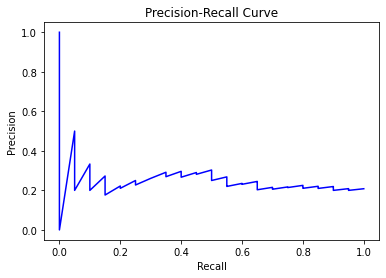

In [40]:
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(validation_class, val_pred_prob)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

If we are interested in a threshold that results in the best balance of precision and recall, then this is the same as optimizing the F-measure that summarizes the harmonic mean of both measures.

F-Measure = (2 * Precision * Recall) / (Precision + Recall)

In [41]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
maks = max(fscore)
ix = np.where(fscore==maks)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.554236, F-Score=0.377


<ipython-input-41-8947b03a276b>:1: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


### Test predictions

In [42]:
test_pred_prob = best_model.predict_proba(test_features)[:,1]

In [43]:
test_features = test_features.reset_index()
test_features = test_features.sort_values(by='loan_application_id')

In [44]:
test_pred = (test_pred_prob >= 0.554236).astype(bool)
test_pred = pd.DataFrame(test_pred,columns=['prediction'])
test_pred['prediction'] = np.where(test_pred['prediction'] == False , 0 , 1)

In [45]:
test_final = pd.concat([test_features,test_pred],axis=1)

In [46]:
test_final[test_final['prediction']==1].shape[0]

151

In [47]:
test_final.shape[0]

847

In [48]:
test_submit = test_final[['loan_application_id', 'prediction']].reset_index(drop=True)

In [50]:
test_submit.to_csv(r'C:\Users\IKG\Desktop\HW5_test_predictions.csv',index=False)